# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [2]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  2.440995  0.642993  0.0  0.778283  2.041183  1.285129  2  0  29.945059   
1  1.169830  0.623222  0.0  0.355537  0.547481  3.072735  2  0  25.335306   
2  1.541462  0.877278  0.0  0.669897  1.380047  0.645118  2  3  27.666318   
3  1.354847 -0.368794  1.0  0.752454  1.023419 -0.429112  0  2  25.126197   
4 -1.766907  1.854294  1.0  0.964881  0.669754 -0.481701  3  0  36.692136   

            y  
0  500.669176  
1  379.801340  
2  448.013552  
3  268.487492  
4  537.020430  
True causal estimate is 11.41935613963594


In [3]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


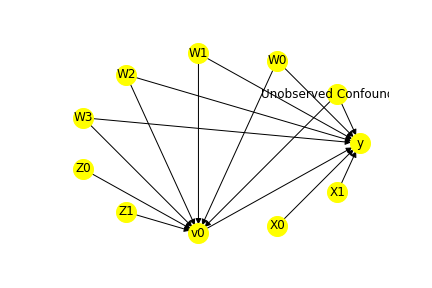

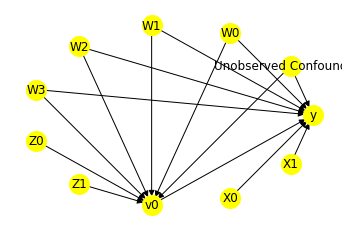

In [4]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [5]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                                    
─────(Expectation(y|X0,W1,W2,X1,W3,W0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,X0,W1,W2,X1,W3,W0,U) = P(y|v0,X0,W1,W2,X1,W3,W0)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
  d                                 
─────(Expectation(y|X0,W1,W2,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,X0,W1,W2,W3,W0,U) = P(y|v0,X0,W1,W2,W3,W0)

### Estimand : 3
Estimand name: backdoor3
Estimand expression:
  d                                 
─────(Expectation(y|W1,W2,X1,W3,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,X1,W3,W0,U) = P(y|v0,W1,W2,X1,W3,W0)

### Estimand : 4
Estimand name: backdoor4
Estimand expression:
  d        

## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [6]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

INFO:dowhy.causal_estimator:b: y~v0+X0+W1+W2+X1+W3+W0+v0*X0+v0*X1
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X0+W1+W2+X1+W3+W0+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 11.419213836842625
### Conditional Estimates
__categorical__X0  __categorical__X1
(-4.101, -1.144]   (-3.677, -0.345]      3.944511
                   (-0.345, 0.234]       7.211124
                   (0.234, 0.738]        9.241715
                   (0.738, 1.325]       11.375095
                   (1.325, 4.101]       14.626516
(-1.144, -0.544]   (-3.677, -0.345]      5.184249
                   (-0.345, 0.234]       8.567651
                   (0.234, 0.738]       10.652493
                   (0.738, 1.325]       12.575686
                   (1.325, 4.101]       15.902688
(-0.544, -0.0321]  (-3.677, -0.345]      5.957273
                   (-0.345, 0.234]       9.382889
                   (0.234, 0.738]       11.369572
                   (0.738, 1.325]       13.469283
                   (1.325, 4.101] 

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 14.138236854016785
Effect estimates: [15.94743858 14.00775091 15.52899766 10.46650634 14.72233559 18.284891
 19.70184877 16.39218666 14.50050829  9.47603982 18.4896821  17.72038559
  9.99439087 16.32879887 14.3621473  10.59405844 12.15297267 14.60540962
 15.28159007 15.00757756 19.42956091 11.47465651 17.13621819 17.52421842
 14.27219716 18.10617719 15.92828249 11.43064155 12.75966685 11.30284753
 19.67379272 15.63235502 16.13038056 16.50969207 11.88553523 17.79775533
 17.15791911 17.97361428  9.35945951 10.99764628  8.93350501 14.39301086
  6.55149159  7.42729849 13.90260559 10.64332141 11.90329718 11.95440101
 13.37854956 18.22591418 13.65724906 14.0770111  10.86527836 19.55670891
 16.14204262 10.98143357 19.47417849 15.56640945 13.63837053 13.43764637
 10.53979153 12.37333017 

In [8]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.41935613963594


In [9]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
Target units: 

## Estimate
Mean value: 11.347864974541409
Effect estimates: [16.23726339 14.16811285 15.72870525 ... 11.26073575  9.04698658
  7.37574131]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
Target units: ate

## Estimate
Mean value: 11.407815504244002
Effect estimates: [16.19221903 14.17618652 15.74131608 ... 11.37746819  9.10985687
  7.36541614]
95.0% confidence interval: (array([16.19103541, 14.25108173, 15.82469701, ..., 11.48900908,
        9.13143126,  7.26709626]), array([16.76051958, 14.61039238, 16.28053275, ..., 11.72570767,
        9.30735769,  7.47806695]))



### Can provide a new inputs as target units and estimate CATE on them.

In [11]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1


[11.65216852 11.22474371 12.65094583 12.3541015  11.02996338 12.62791703
 13.29774728 12.16247731 11.2183901  11.12422732]


### Can also retrieve the raw EconML estimator object for any further operations

In [12]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [13]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.886744 -0.853784  1.0  0.969098 -1.190924  1.416170  0.605130   
1    -0.482295  0.530378  0.0  0.872681 -0.857013  1.634616 -0.689932   
2    -0.822027  0.917922  0.0  0.172821 -0.471884  1.075380  1.403325   
3    -0.678540  1.067071  0.0  0.713264 -1.319941  0.462407 -0.376109   
4     0.194840  0.374447  1.0  0.375834 -0.541836  2.344965 -2.078082   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.407969  2.414654  0.0  0.173091 -0.742176  0.237256 -0.045578   
9996  0.234307  2.070275  1.0  0.717266  0.342456  1.164750  1.152267   
9997  0.285876  1.415326  0.0  0.127318 -0.388663  1.240178 -1.385993   
9998  0.202024  0.862294  0.0  0.510710 -1.658731  1.621617  0.291852   
9999 -0.712113  0.188391  0.0  0.474279 -0.229532  0.164215 -0.348039   

            W3  v0  y  
0     1.943761   1  1  
1     0.513464   1  1  
2     0.985433   1  1  
3    -0.146830   1  1  
4  

#### Using DRLearner estimator

In [14]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
Target units: ate

## Estimate
Mean value: 0.6603502228744639
Effect estimates: [0.75630269 0.65875525 0.63442904 ... 0.70898338 0.70473832 0.64393769]

True causal estimate is 0.4426


### Instrumental Variable Method

In [15]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model._instruments)+len(model._effect_modifiers)
dims_tx = len(model._treatment)+len(model._effect_modifiers)
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Using TensorFlow backend.
W0127 14:24:47.653102 42240 deprecation.py:506] From C:\Users\moprescu\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0127 14:24:47.920775 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:24:47.944677 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
W0127 14:24:48.138261 42240 deprecation.py:323] From C:\Users\moprescu\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\ops\math_ops.py:2509: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0127 14:24:49.731560 42240 module_wrapper.

Epoch 1/25
10000/10000 [==============================] - 2s 172us/step - loss: 13.7977
Epoch 2/25
10000/10000 [==============================] - 1s 121us/step - loss: 4.2891
Epoch 3/25
10000/10000 [==============================] - 1s 104us/step - loss: 3.5534
Epoch 4/25
10000/10000 [==============================] - 1s 94us/step - loss: 2.8957
Epoch 5/25
10000/10000 [==============================] - 1s 97us/step - loss: 2.8148
Epoch 6/25
10000/10000 [==============================] - 1s 92us/step - loss: 2.7685
Epoch 7/25
10000/10000 [==============================] - 1s 95us/step - loss: 2.7486
Epoch 8/25
10000/10000 [==============================] - 1s 94us/step - loss: 2.7289
Epoch 9/25
10000/10000 [==============================] - 1s 96us/step - loss: 2.7218
Epoch 10/25
10000/10000 [==============================] - 1s 97us/step - loss: 2.7110
Epoch 11/25
10000/10000 [==============================] - 1s 99us/step - loss: 2.7003
Epoch 12/25
10000/10000 [=======================

### Metalearners

In [16]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

I0127 14:26:23.871664 42240 causal_model.py:362] Model to find the causal effect of treatment ['v0'] on outcome ['y']


            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.275795  0.380984 -1.104488  0.207749  0.105785  0.0  0.469232   
1     0.693888 -0.362574 -1.707820  0.252355  0.035017  0.0  0.281143   
2     1.099880  0.688432  0.066359 -0.607856 -0.143397  0.0  0.104659   
3    -0.717708 -1.052710 -1.963322  1.240659  1.839630  0.0  0.282046   
4     0.101035  0.268951  0.018142 -2.492610  1.627336  0.0  0.802720   
...        ...       ...       ...       ...       ...  ...       ...   
9995  1.532624 -0.638619 -0.011745  0.489396  2.086348  0.0  0.925902   
9996  1.126562  3.033536 -1.029231 -0.829854 -0.458543  0.0  0.129945   
9997 -0.591017  0.342206 -2.353809  0.232832 -0.329933  0.0  0.938582   
9998 -1.270411  0.435721  0.600667 -0.462455 -1.249542  0.0  0.728551   
9999 -1.417279  2.854329 -1.174070  0.405475 -0.277458  0.0  0.422851   

            W0        W1        W2        W3        W4  v0          y  
0    -0.291522  0.597402  0.653913 -0.460163 -1.388

W0127 14:26:24.042665 42240 causal_identifier.py:311] If this is observed data (not from a randomized experiment), there might always be missing confounders. Causal effect cannot be identified perfectly.
I0127 14:26:24.044665 42240 causal_identifier.py:315] Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
I0127 14:26:24.068666 42240 causal_identifier.py:81] Instrumental variables for treatment and outcome:['Z0', 'Z1']
I0127 14:26:24.078703 42240 causal_identifier.py:98] Frontdoor variables for treatment and outcome:[]


In [17]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

I0127 14:26:24.115667 42240 econml.py:14] INFO: Using EconML Estimator
W0127 14:26:24.118667 42240 econml.py:36] Concatenating common_causes and effect_modifiers and providing a single list of variables to metalearner estimator method, TLearner. EconML metalearners accept a single X argument.
I0127 14:26:24.182673 42240 econml.py:64] b: y~v0+X0+X4+X1+X3+X2+W1+W2+W3+W4+W0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X0+X4+X1+X3+X2+W1+W2+W3+W4+W0
Target units: ate

## Estimate
Mean value: 16.46297322429818
Effect estimates: [14.60212587 10.90581822 20.30077674 ...  3.58314192  6.95501596
 10.7718181 ]

True causal estimate is 10.704794147933528


## Refuting the estimate

### Random 

In [18]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

I0127 14:26:40.329043 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:26:40.366050 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1


Refute: Add a Random Common Cause
Estimated effect:11.93426819686473
New effect:11.912782106898028



### Adding an unobserved common cause variable

In [19]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

I0127 14:26:49.323786 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:26:49.357791 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1


Refute: Add an Unobserved Common Cause
Estimated effect:11.93426819686473
New effect:11.86448564562512



### Replacing treatment with a random (placebo) variable

In [20]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

I0127 14:26:56.428257 42240 placebo_treatment_refuter.py:62] Refutation over 10 simulated datasets of permute treatment
I0127 14:26:56.451784 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:26:56.485782 42240 econml.py:64] b: y~placebo+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:27:03.948302 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:27:03.988827 42240 econml.py:64] b: y~placebo+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:27:10.837531 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:27:10.866532 42240 econml.py:64] b: y~placebo+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:27:17.819891 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:27:17.851894 42240 econml.py:64] b: y~placebo+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:27:24.620854 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:27:24.658856 42240 econml.py:64] b: y~placebo+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:27:31.551115 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:27:31.579114 42240 econml.py:64] b: y~pl

Refute: Use a Placebo Treatment
Estimated effect:11.93426819686473
New effect:0.005287741572659588
p value:0.47147586328572394



### Removing a random subset of the data

In [21]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

I0127 14:28:06.508193 42240 data_subset_refuter.py:40] Refutation over 0.8 simulated datasets of size 8000.0 each
I0127 14:28:06.529192 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:28:06.566197 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:28:12.653506 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:28:12.682510 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:28:18.658183 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:28:18.685183 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:28:24.353640 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:28:24.379688 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:28:29.712384 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:28:29.740379 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
I0127 14:28:35.102230 42240 econml.py:14] INFO: Using EconML Estimator
I0127 14:28:35.125229 42240 econml.py:64] b: y~v0+X0+W1+W2+X1+W3+W0 | X0,X1
I012

Refute: Use a subset of data
Estimated effect:11.93426819686473
New effect:11.863837768141686
p value:0.045090106742808334



More refutation methods to come, especially specific to the CATE estimators.